# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План:

- **1. Исследование данных:**
        - изучить данные
        - подправить типы данных
        - проанализировать каждую таблицу поотдельности
        - проанализировать температуры
- **2. Предобработка данных:**
        - проверить на дубликаты
        - проверить на пропуски
        - проверить на аномалии
        - изучить корреляцию
        - агрегация по ключу
        - доп признаки(полная мощность)
        - собрать в отдельную таблицу нужные признаки на которых будет обучаться модель
        - температуру оставить начальную и конечную, можно посичтать за сколько времени достиглась конечная температура
        - произвести маштабирование признаков еси это нужно 
- **3. Разработка модели:**
        - разделить данные на обучающуюи тестовую выборки
        - обучить +-3 модели с помощью крос-валидации, посмотреть на результаты MAE
        - выбрать лучшую модель и протестировать ее на тестовой выборке по показателю MAE
        - проанализировать врмя обучения и предсказание лучшей модели (доп)
- **4. Отчет**
- **5. Итоговый вывод, рекомендации комбинату**



## Исследование и предобработка данных

In [1]:
#библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import pylab

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from numpy.random import RandomState
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
import time
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_STATE = 60623

In [3]:
data_arc=pd.read_csv('/datasets/data_arc_new.csv')
data_bulk=pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas=pd.read_csv('/datasets/data_gas_new.csv')
data_temp=pd.read_csv('/datasets/data_temp_new.csv')
data_wire=pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time=pd.read_csv('/datasets/data_wire_time_new.csv')

data_arc=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_arc_new.csv')
data_bulk=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_bulk_new.csv')
data_bulk_time=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_bulk_time_new.csv')
data_gas=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_gas_new.csv')
data_temp=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_temp_new.csv')
data_wire=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_wire_new.csv')
data_wire_time=pd.read_csv('C:/Users/ekate/Desktop/итоговый проект/data_wire_time_new.csv')

In [4]:
data_arc['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

### data_arc

In [5]:
data_arc.head(10) #данные об электродах;

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50  2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19  2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48  2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54  2019-05-03 12:11:34           1.101678   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962  
8             0.542517  
9             0.820856

In [6]:
print(data_arc.info())
print('-' * 100)


print('ПРОПУСКИ data_arc')
print(data_arc.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ ddata_arc', data_arc.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_arc
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
----------------------------------------------------------------------------------------------------
ДУБЛИКАТЫ ddata_arc 0
---------------------------------------------------------------------------------

In [7]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [8]:
data_arc.describe() 

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

In [9]:
data_arc.pivot_table(index=['key'], values='Активная мощность', aggfunc='count').rename(
    columns={'key':'key', 'Активная мощность':'Количество key'})

Количество key
key                 
1                  5
2                  4
3                  5
4                  4
5                  4
...              ...
3237               5
3238               3
3239               8
3240               5
3241               5

[3214 rows x 1 columns]

In [10]:
data_arc.corr()

key  Активная мощность  Реактивная мощность
key                  1.000000          -0.010220            -0.004834
Активная мощность   -0.010220           1.000000             0.031164
Реактивная мощность -0.004834           0.031164             1.000000

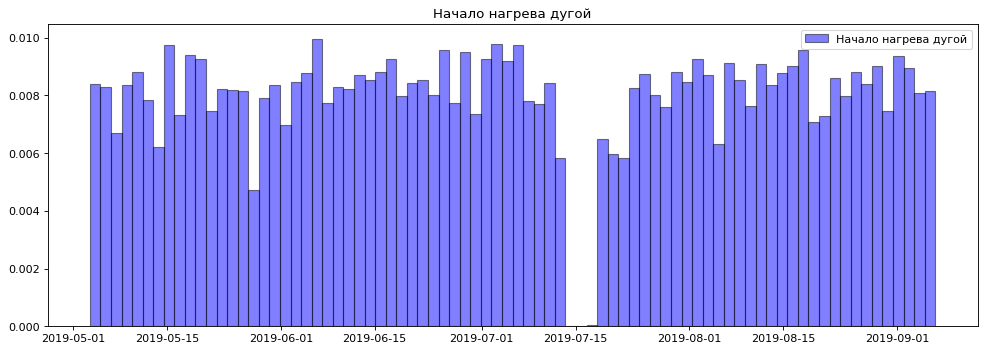

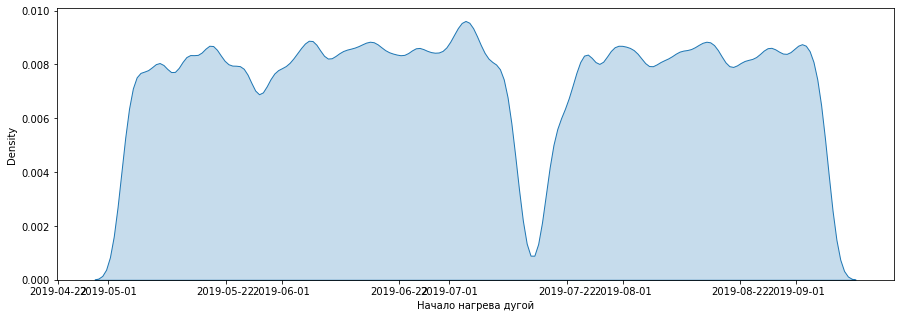

In [11]:
plt.figure(figsize=(15,5), dpi= 80)
plt.hist(data_arc['Начало нагрева дугой'], density = True, histtype ='bar', color = 'blue', label = 'Начало нагрева дугой', edgecolor = 'black', bins = 80, alpha=0.5) 
plt.legend(prop ={'size': 10}) 
plt.title('Начало нагрева дугой')
plt.show()

plt.figure(figsize=(15,5))
sns.kdeplot(data_arc['Начало нагрева дугой'], shade = True ,  bw_adjust=0.3)
plt.show()

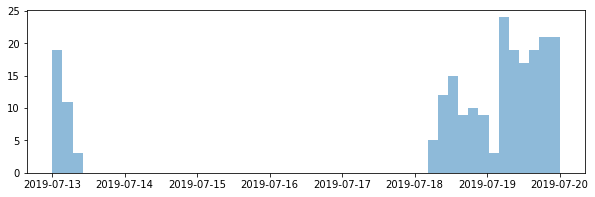

In [12]:
plt.figure(figsize=(10,3))
plt.hist(
    data_arc['Начало нагрева дугой'][('2019-07-13' < data_arc['Начало нагрева дугой']) 
             & (data_arc['Начало нагрева дугой'] < '2019-07-20')],
    bins = 50, 
    alpha=0.5,
    histtype ='bar')
plt.show()
# С 14 по 18 июля нет данных об электродах.

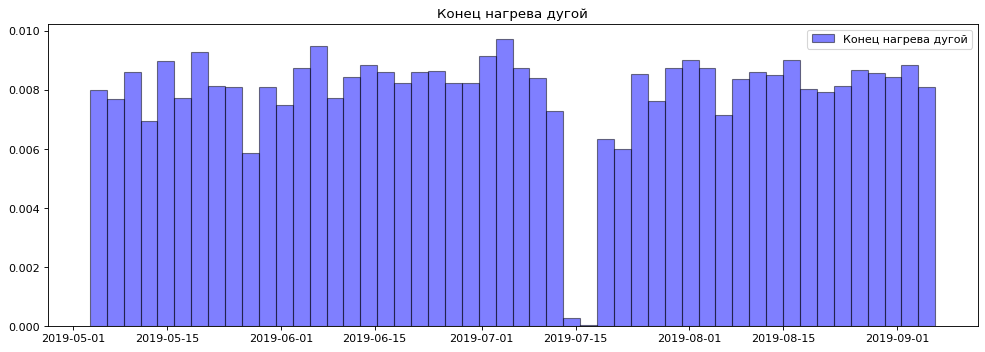

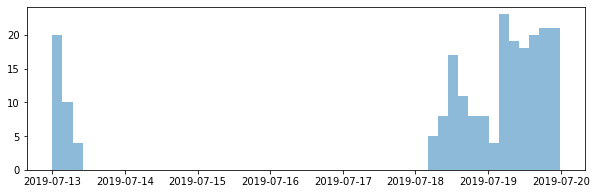

In [13]:
plt.figure(figsize=(15,5), dpi= 80)
plt.hist(data_arc['Конец нагрева дугой'], density = True, histtype ='bar', color = 'blue', label = 'Конец нагрева дугой', edgecolor = 'black', bins = 50, alpha=0.5) 
plt.legend(prop ={'size': 10}) 
plt.title('Конец нагрева дугой')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(
    data_arc['Конец нагрева дугой'][('2019-07-13' < data_arc['Конец нагрева дугой']) 
             & (data_arc['Конец нагрева дугой'] < '2019-07-20')],
    bins = 50, 
    alpha=0.5,
    histtype ='bar')
plt.show()
# С 14 по 18 июля нет данных об электродах аналогично

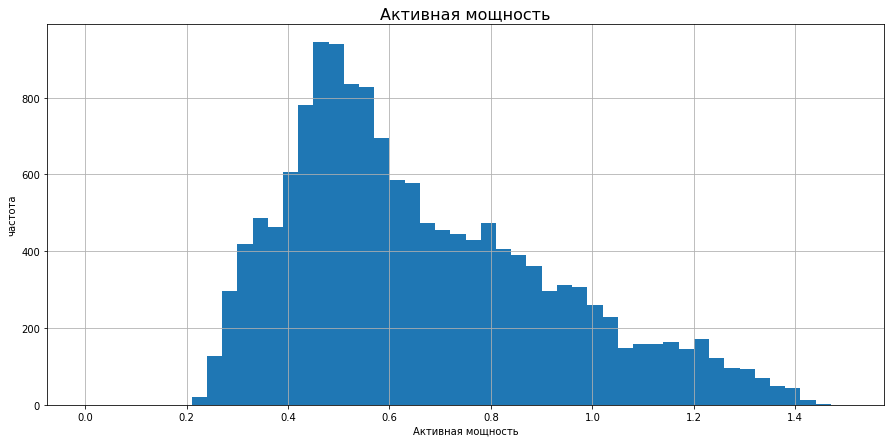

In [14]:
data_arc['Активная мощность'].hist(bins = 50, figsize = (15,7), range = (0,1.5))
plt.xlabel('Активная мощность', fontsize=10)
plt.ylabel('частота', fontsize=10)
plt.title('Активная мощность', fontsize=16);

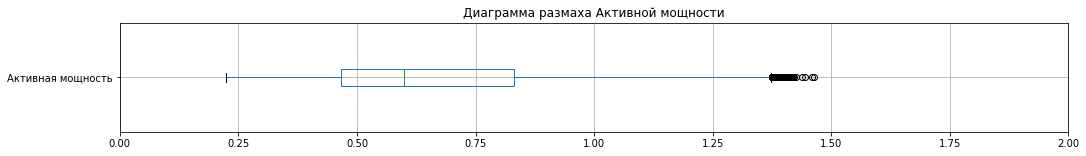

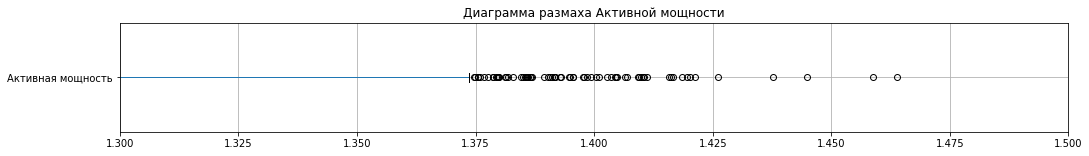

In [15]:
# boxplot для Активной мощности 
fig, ax = plt.subplots(figsize = (17,2))
ax = data_arc[['Активная мощность']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха Активной мощности')
ax.set_xlim(0,2)
plt.show()

fig, ax = plt.subplots(figsize = (17,2))
ax = data_arc[['Активная мощность']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха Активной мощности')
ax.set_xlim(1.3,1.5)
plt.show()

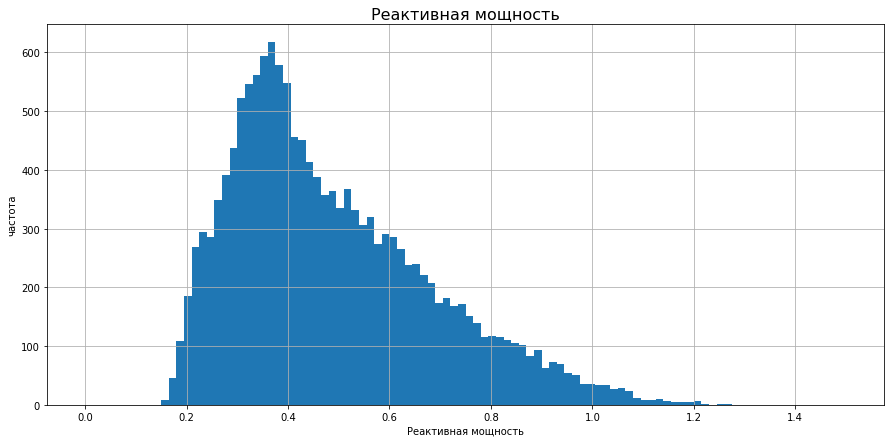

In [16]:
data_arc['Реактивная мощность'].hist(bins = 100, figsize = (15,7), range = (0,1.5))
plt.xlabel('Реактивная мощность', fontsize=10)
plt.ylabel('частота', fontsize=10)
plt.title('Реактивная мощность', fontsize=16);

In [17]:
data_arc[data_arc['Реактивная мощность']<=0]
#Может ли такое быть, да и все числа в пределах от 0 до 1, а тут аж -715, думаю удалить???

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08 2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

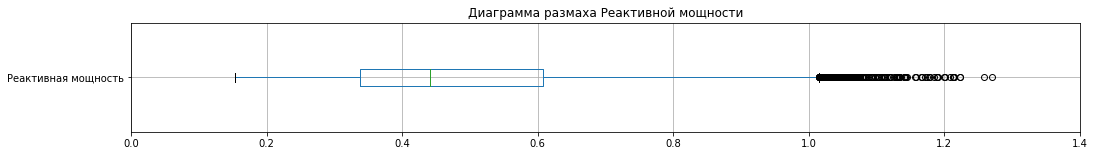

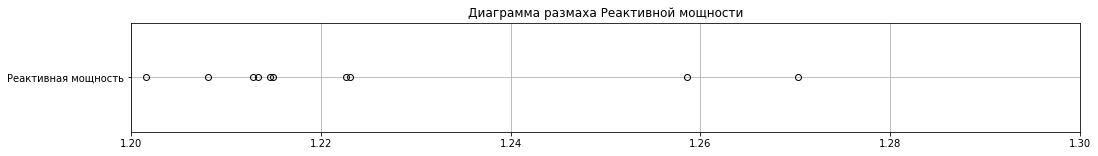

In [18]:
# boxplot для Реактивной мощности без отрицательного одного значения
fig, ax = plt.subplots(figsize = (17,2))
ax = data_arc[['Реактивная мощность']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха Реактивной мощности')
ax.set_xlim(0,1.4)
plt.show()

fig, ax = plt.subplots(figsize = (17,2))
ax = data_arc[['Реактивная мощность']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха Реактивной мощности')
ax.set_xlim(1.2,1.3)
plt.show()

Есть аномалии больше 1,425 в Активной мощности, и больше 1,22 в Реактивной мощности. Так же имеется отрицательная мощность, в наших условиях она не может получится ее точно убираем. У реактивной и активной мощности нормальное распределение правдо скошенной в право std у активной м. 0.258894 а у реактивной м. 0,197612. 

In [19]:
data_arc = data_arc[data_arc['Реактивная мощность']>=0]

### data_bulk

In [20]:
data_bulk.head() #данные о подаче сыпучих материалов (объём);

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [21]:
print(data_bulk.info())
print('-' * 100)


print('ПРОПУСКИ data_bulk')
print(data_bulk.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ data_bulk', data_bulk.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_bulk
key           0
Bulk 1     2877

In [22]:
data_bulk.describe() 
# В Bulk 8 одно значение видно сразу, остальное пропуски

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [23]:
data_bulk_0 = data_bulk.fillna('0')
data_bulk_0.pivot_table(index=['key'], values='Bulk 1', aggfunc='count').rename(
    columns={'key':'key', 'Bulk 1':'Количество key'})

Количество key
key                 
1                  1
2                  1
3                  1
4                  1
5                  1
...              ...
3237               1
3238               1
3239               1
3240               1
3241               1

[3129 rows x 1 columns]

In [24]:
data_bulk[data_bulk['Bulk 8'] > 0]

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
1725  1786     NaN     NaN   123.0     NaN     NaN     NaN     NaN    49.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
1725   147.0      NaN      NaN      NaN      NaN      NaN      NaN

In [25]:
data_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [26]:
data_bulk[(data_bulk['Bulk 1'].isna() == True) & 
         (data_bulk['Bulk 2'].isna() == True) & 
         (data_bulk['Bulk 3'].isna() == True) &
         (data_bulk['Bulk 4'].isna() == True) &
         (data_bulk['Bulk 5'].isna() == True)&
         (data_bulk['Bulk 6'].isna() == True)&
         (data_bulk['Bulk 7'].isna() == True)&
         (data_bulk['Bulk 8'].isna() == True)&
         (data_bulk['Bulk 9'].isna() == True)&
         (data_bulk['Bulk 10'].isna() == True)&
         (data_bulk['Bulk 11'].isna() == True)&
         (data_bulk['Bulk 12'].isna() == True)&
         (data_bulk['Bulk 13'].isna() == True)&
         (data_bulk['Bulk 14'].isna() == True)&
         (data_bulk['Bulk 15'].isna() == True)]

Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []

Text(0.5, 1.0, 'Bulk 15')

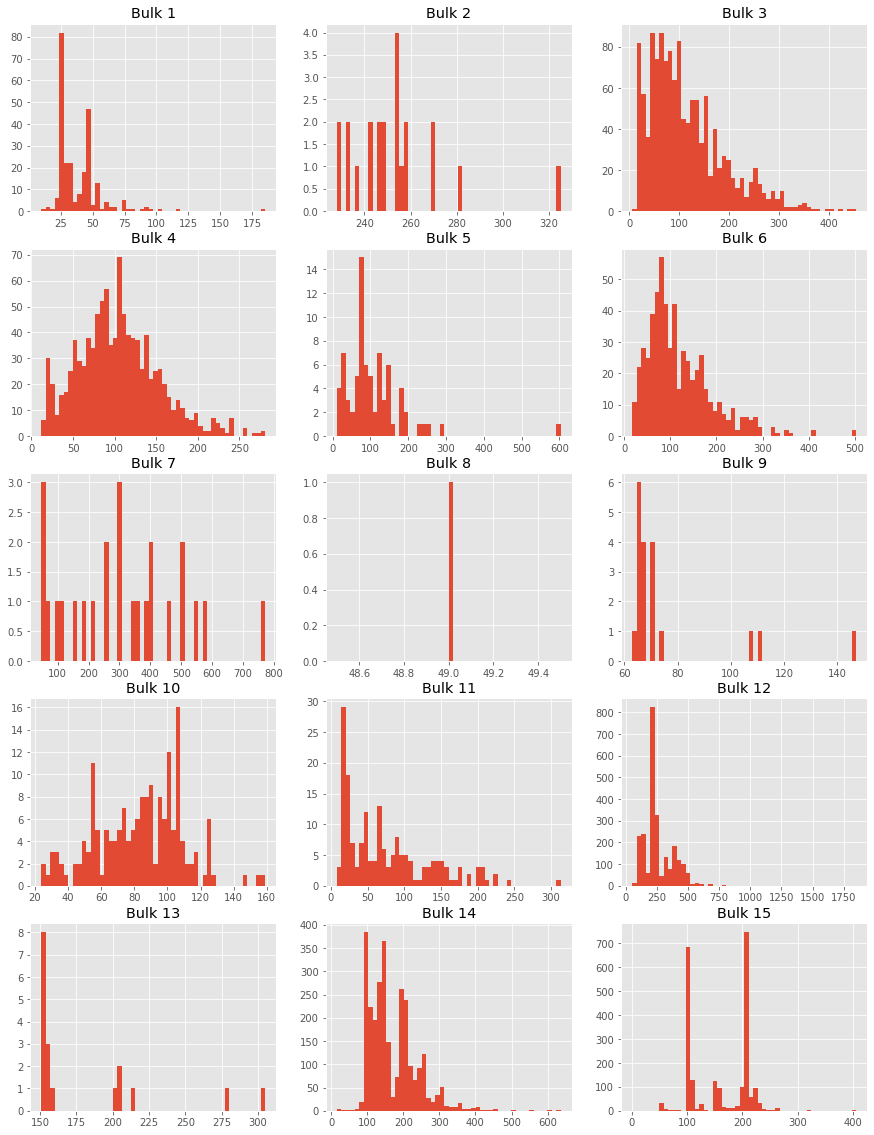

In [27]:

plt.figure(figsize=(15,20))
plt.style.use('ggplot')

pylab.subplot (5, 3, 1)
pylab.hist(data_bulk['Bulk 1'], bins = 50)
pylab.title ("Bulk 1")

pylab.subplot (5, 3, 2)
pylab.hist(data_bulk['Bulk 2'], bins = 50)
pylab.title ("Bulk 2")

pylab.subplot (5, 3, 3)
pylab.hist(data_bulk['Bulk 3'], bins = 50)
pylab.title ("Bulk 3")

pylab.subplot (5, 3, 4)
pylab.hist(data_bulk['Bulk 4'], bins = 50)
pylab.title ("Bulk 4")

pylab.subplot (5, 3, 5)
pylab.hist(data_bulk['Bulk 5'], bins = 50)
pylab.title ("Bulk 5")

pylab.subplot (5, 3, 6)
pylab.hist(data_bulk['Bulk 6'], bins = 50)
pylab.title ("Bulk 6")

pylab.subplot (5, 3, 7)
pylab.hist(data_bulk['Bulk 7'], bins = 50)
pylab.title ("Bulk 7")

pylab.subplot (5, 3, 8)
pylab.hist(data_bulk['Bulk 8'], bins = 50)
pylab.title ("Bulk 8")

pylab.subplot (5, 3, 9)
pylab.hist(data_bulk['Bulk 9'], bins = 50)
pylab.title ("Bulk 9")

pylab.subplot (5, 3, 10)
pylab.hist(data_bulk['Bulk 10'], bins = 50)
pylab.title ("Bulk 10")

pylab.subplot (5, 3, 11)
pylab.hist(data_bulk['Bulk 11'], bins = 50)
pylab.title ("Bulk 11")

pylab.subplot (5, 3, 12)
pylab.hist(data_bulk['Bulk 12'], bins = 50)
pylab.title ("Bulk 12")

pylab.subplot (5, 3, 13)
pylab.hist(data_bulk['Bulk 13'], bins = 50)
pylab.title ("Bulk 13")

pylab.subplot (5, 3, 14)
pylab.hist(data_bulk['Bulk 14'], bins = 50)
pylab.title ("Bulk 14")

pylab.subplot (5, 3, 15)
pylab.hist(data_bulk['Bulk 15'], bins = 50)
pylab.title ("Bulk 15")

Bulk 1 добавляли меньше всего. Больше всего добавляли Bulk 7. А Bulk 3, Bulk4, Bulk 6 самые часто использеумые. 

### data_bulk_time

In [28]:
data_bulk_time.head() #данные о подаче сыпучих материалов (время);

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

In [29]:
print(data_bulk_time.info())
print('-' * 100)


print('ПРОПУСКИ data_bulk_time')
print(data_bulk_time.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ data_bulk_time', data_bulk_time.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_bulk_time
key           0
Bulk 1     2877
Bulk 2     3

In [30]:
columns = data_bulk_time.columns.to_list()[1:]
for i in columns:
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i], format='%Y-%m-%d %H:%M:%S')


In [31]:
data_bulk_time_0 = data_bulk_time.fillna('0')
data_bulk_time_0.pivot_table(index=['key'], values='Bulk 1', aggfunc='count').rename(
    columns={'key':'key', 'Bulk 1':'Количество key'})

Количество key
key                 
1                  1
2                  1
3                  1
4                  1
5                  1
...              ...
3237               1
3238               1
3239               1
3240               1
3241               1

[3129 rows x 1 columns]

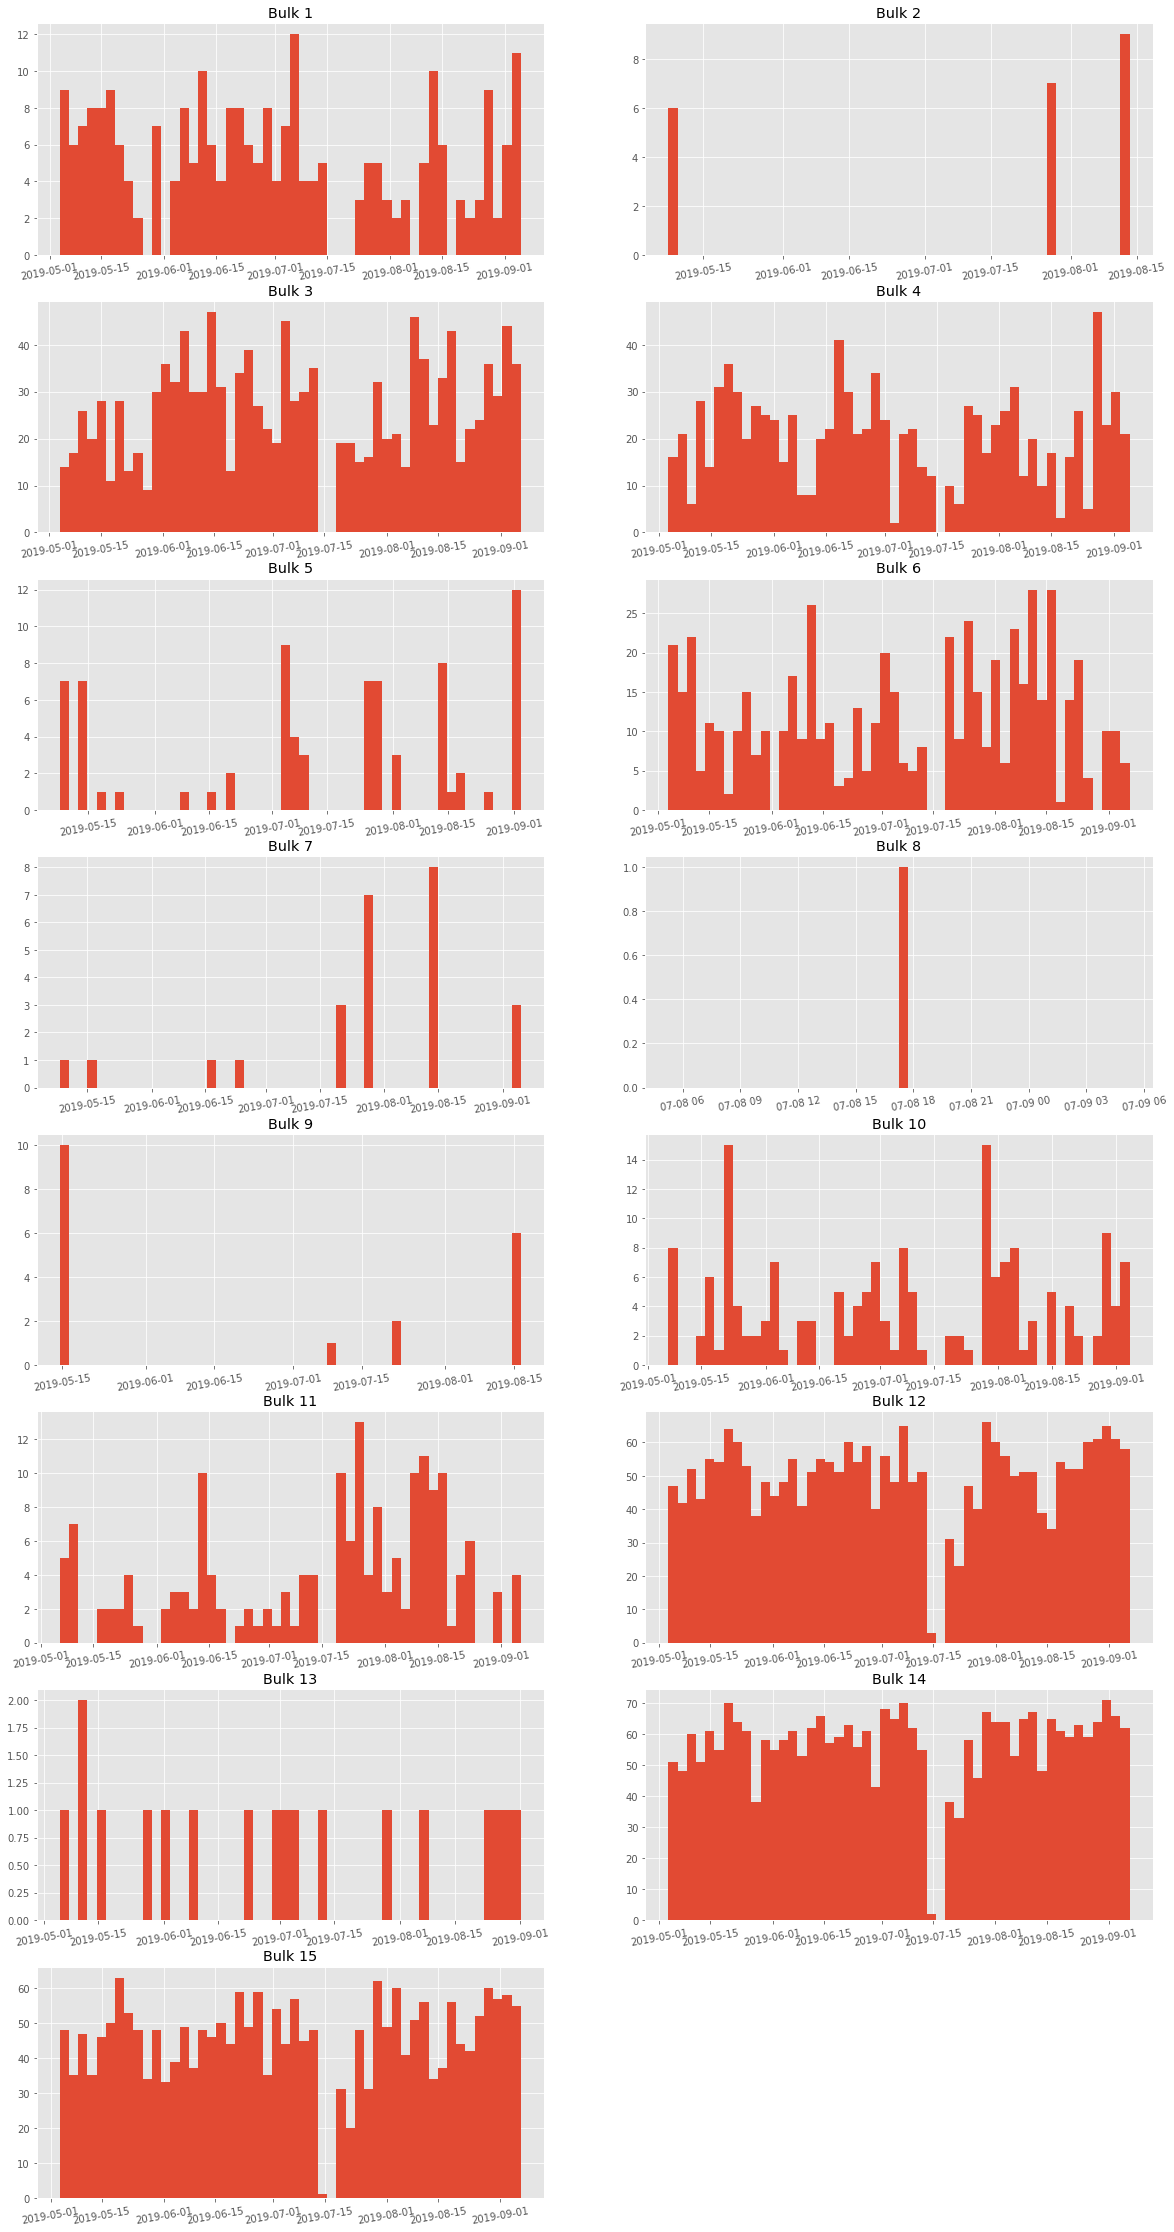

In [32]:

plt.figure(figsize=(20,40))
plt.style.use('ggplot')

pylab.subplot (8, 2, 1)
pylab.hist(data_bulk_time['Bulk 1'], bins = 50)
pylab.title ("Bulk 1")
pylab.xticks(rotation=10)


pylab.subplot (8, 2, 2)
pylab.hist(data_bulk_time['Bulk 2'], bins = 50)
pylab.title ("Bulk 2")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 3)
pylab.hist(data_bulk_time['Bulk 3'], bins = 50)
pylab.title ("Bulk 3")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 4)
pylab.hist(data_bulk_time['Bulk 4'], bins = 50)
pylab.title ("Bulk 4")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 5)
pylab.hist(data_bulk_time['Bulk 5'], bins = 50)
pylab.title ("Bulk 5")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 6)
pylab.hist(data_bulk_time['Bulk 6'], bins = 50)
pylab.title ("Bulk 6")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 7)
pylab.hist(data_bulk_time['Bulk 7'], bins = 50)
pylab.title ("Bulk 7")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 8)
pylab.hist(data_bulk_time['Bulk 8'], bins = 50)
pylab.title ("Bulk 8")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 9)
pylab.hist(data_bulk_time['Bulk 9'], bins = 50)
pylab.title ("Bulk 9")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 10)
pylab.hist(data_bulk_time['Bulk 10'], bins = 50)
pylab.title ("Bulk 10")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 11)
pylab.hist(data_bulk_time['Bulk 11'], bins = 50)
pylab.title ("Bulk 11")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 12)
pylab.hist(data_bulk_time['Bulk 12'], bins = 50)
pylab.title ("Bulk 12")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 13)
pylab.hist(data_bulk_time['Bulk 13'], bins = 50)
pylab.title ("Bulk 13")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 14)
pylab.hist(data_bulk_time['Bulk 14'], bins = 50)
pylab.title ("Bulk 14")
pylab.xticks(rotation=10)

pylab.subplot (8, 2, 15)
pylab.hist(data_bulk_time['Bulk 15'], bins = 50)
pylab.title ("Bulk 15")
pylab.xticks(rotation=10)
plt.show()

Заметила пропуски в июле те же что и по таблице data_arc ( По Bulk 12, 14, 15 прям хорошо видно)

### data_gas

In [33]:
data_gas.head() #данные о продувке сплава газом;

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [34]:
print(data_gas.info())
print('-' * 100)


print('ПРОПУСКИ data_gas')
print(data_gas.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ data_gas', data_gas.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_gas
key      0
Газ 1    0
dtype: int64
----------------------------------------------------------------------------------------------------
ДУБЛИКАТЫ data_gas 0
----------------------------------------------------------------------------------------------------


In [35]:
data_gas.pivot_table(index=['key'], values='Газ 1', aggfunc='count').rename(
    columns={'key':'key', 'Газ 1':'Количество key'})

Количество key
key                 
1                  1
2                  1
3                  1
4                  1
5                  1
...              ...
3237               1
3238               1
3239               1
3240               1
3241               1

[3239 rows x 1 columns]

In [36]:
data_gas.describe() 

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

<AxesSubplot:>

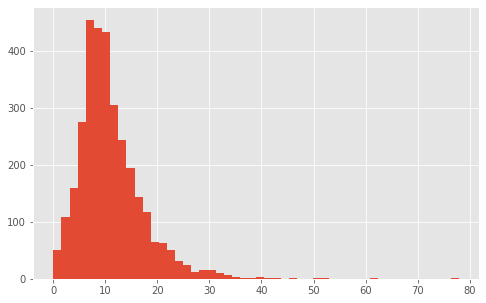

In [37]:
plt.figure(figsize=(8,5))
data_gas['Газ 1'].hist(bins=50)

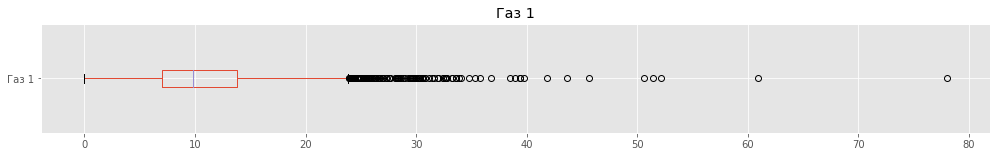

In [38]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_gas[['Газ 1']].boxplot(vert = False, ax =ax)
ax.set_title('Газ 1')
#ax.set_xlim(40,80)
plt.show()

Присутствуют достаточно большие зачения (анамалии), но думаю такие ситуации могут существовать, видимо в каких то опытах пробовали больше добавить газа и смотрели к какой температуре это приведет, видимо результат не нравился поэтому случаи единичные.  Удалять не будем. 

### data_temp

In [39]:
data_temp.head()  #результаты измерения температуры;

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

In [40]:
print(data_temp.info())
print('-' * 100)


print('ПРОПУСКИ data_temp')
print(data_temp.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ data_temp', data_temp.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_temp
key                0
Время замера       0
Температура     3427
dtype: int64
----------------------------------------------------------------------------------------------------
ДУБЛИКАТЫ data_temp 0
----------------------------------------------------------------------------------------------------


In [41]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [42]:
data_temp.describe() 

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

In [43]:
data_temp_0= data_temp.fillna('0')
data_temp_0.pivot_table(index=['key'], values='Температура', aggfunc='count').rename(
    columns={'key':'key', 'Температура':'Количество key'})

Количество key
key                 
1                  6
2                  5
3                  6
4                  5
5                  5
...              ...
3237               6
3238               4
3239               9
3240               6
3241               6

[3216 rows x 1 columns]

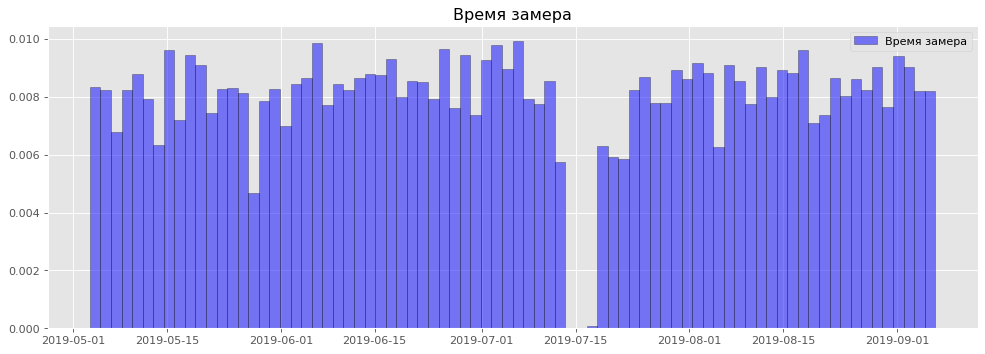

In [44]:
plt.figure(figsize=(15,5), dpi= 80)
plt.hist(data_temp['Время замера'], density = True, histtype ='bar', color = 'blue', label = 'Время замера', edgecolor = 'black', bins = 80, alpha=0.5) 
plt.legend(prop ={'size': 10}) 
plt.title('Время замера')
plt.show()

Опять нет значений в июле в те 5 дней, может была какая-то поломка.

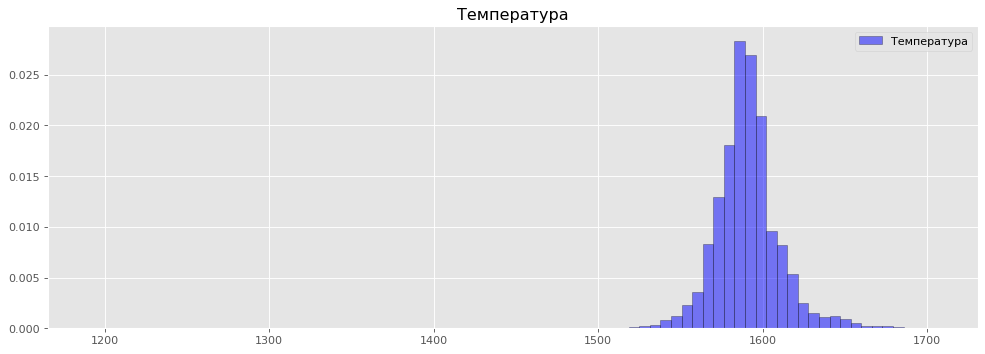

In [45]:
plt.figure(figsize=(15,5), dpi= 80)
plt.hist(data_temp['Температура'], density = True, histtype ='bar', color = 'blue', label = 'Температура', edgecolor = 'black', bins = 80, alpha=0.5) 
plt.legend(prop ={'size': 10}) 
plt.title('Температура')
plt.show()

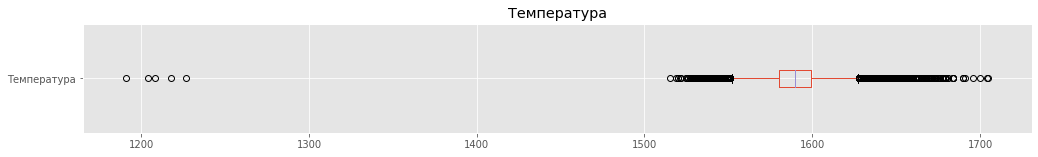

In [46]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_temp[['Температура']].boxplot(vert = False, ax =ax)
ax.set_title('Температура')
#ax.set_xlim(1500,1730)
plt.show()

Вижу аномальные значения ниже 1300 и выше 1680. Уберем все что ниже 1500 так как говорил заказчик. 

In [47]:
data_temp[data_temp['Температура']<=1500]

key        Время замера  Температура
4883    867 2019-06-06 08:03:39       1191.0
6784   1214 2019-06-18 08:01:03       1208.0
9050   1619 2019-07-03 02:34:41       1218.0
11495  2052 2019-07-25 08:49:15       1227.0
14283  2561 2019-08-12 18:49:29       1204.0

In [48]:
data_temp[data_temp['key']==867]

key        Время замера  Температура
4883  867 2019-06-06 08:03:39       1191.0
4884  867 2019-06-06 08:18:52       1575.0
4885  867 2019-06-06 08:22:38       1576.0
4886  867 2019-06-06 08:25:11       1571.0
4887  867 2019-06-06 08:29:49       1600.0
4888  867 2019-06-06 08:36:49       1522.0
4889  867 2019-06-06 08:43:02       1521.0
4890  867 2019-06-06 08:48:23       1599.0

In [49]:
#data_temp = data_temp[data_temp['Температура']>=1500]

Считаю не разумным удалить ключи у которых температура попадается ниже 1500, потому что в некоторых много достаточно итераций.


Во второй части проекта когда оставлю только 1 и последнию тепературу, проверю ушли ли эти значения или нет, если где то не ушли то тогда удалю послностью ключ. 

### data_wire

In [50]:
data_wire.head()  # данные о проволочных материалах (объём);

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [51]:
print(data_wire.info())
print('-' * 100)


print('ПРОПУСКИ data_wire')
print(data_wire.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ data_wire', data_wire.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_wire
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
----------------------------------------------------------------------------------------------------
ДУБЛИКАТ

In [52]:
data_wire_0 = data_wire.fillna('0')
data_wire_0 = data_wire_0.pivot_table(index=['key'], values='Wire 1', aggfunc='count').rename(
    columns={'key':'key', 'Wire 1':'Количество key'})
data_wire_0[data_wire_0['Количество key'] > 1 ] 
#количество ключей которое попадается больше 1 раза отсутствует

Empty DataFrame
Columns: [Количество key]
Index: []

Text(0.5, 1.0, 'Wire 9')

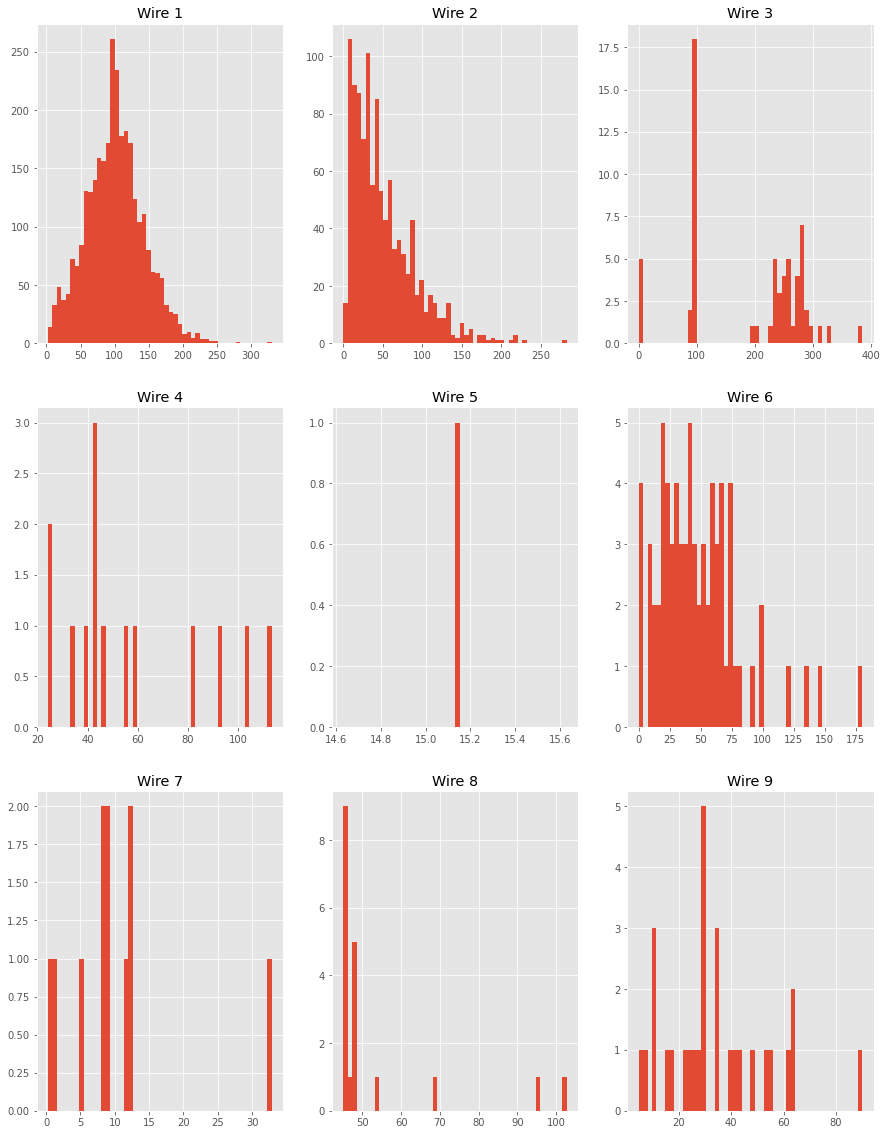

In [53]:
plt.figure(figsize=(15,20))
plt.style.use('ggplot')

pylab.subplot (3, 3, 1)
pylab.hist(data_wire['Wire 1'], bins = 50)
pylab.title ("Wire 1")

pylab.subplot (3, 3, 2)
pylab.hist(data_wire['Wire 2'], bins = 50)
pylab.title ("Wire 2")

pylab.subplot (3, 3, 3)
pylab.hist(data_wire['Wire 3'], bins = 50)
pylab.title ("Wire 3")

pylab.subplot (3, 3, 4)
pylab.hist(data_wire['Wire 4'], bins = 50)
pylab.title ("Wire 4")

pylab.subplot (3, 3, 5)
pylab.hist(data_wire['Wire 5'], bins = 50)
pylab.title ("Wire 5")

pylab.subplot (3, 3, 6)
pylab.hist(data_wire['Wire 6'], bins = 50)
pylab.title ("Wire 6")

pylab.subplot (3, 3, 7)
pylab.hist(data_wire['Wire 7'], bins = 50)
pylab.title ("Wire 7")

pylab.subplot (3, 3, 8)
pylab.hist(data_wire['Wire 8'], bins = 50)
pylab.title ("Wire 8")

pylab.subplot (3, 3, 9)
pylab.hist(data_wire['Wire 9'], bins = 50)
pylab.title ("Wire 9")

У нас всего 9 видов проволочных материалов, и каждый добавляется в разном объеме с разной частотой. По объему больше всего добавлялся 1, 3 и 6, а меньше всего 5, 9 и 7. У первого прям видно что распределение нормальное, думаю самый такой востребованный. Так же вижу что начиная с 4 вида и до 9 добавлялись прям по обнаковому количеству раз определенный из видов, значит это уже не пробовали а знали что так нужно для достижения определенной температры. 

### data_wire_time

In [54]:
data_wire_time.head()  #данные о проволочных материалах (время).

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [55]:
print(data_wire_time.info())
print('-' * 100)


print('ПРОПУСКИ data_wire_time')
print(data_wire_time.isna().sum())
print('-' * 100)
      
print('ДУБЛИКАТЫ data_wire_time', data_wire_time.duplicated().sum())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
----------------------------------------------------------------------------------------------------
ПРОПУСКИ data_wire_time
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
----------------------------------------------------------------------------------------------------
ДУБЛИКАТЫ data_

In [56]:
data_wire_time_0 = data_wire_time.fillna('0')
data_wire_time_0 = data_wire_time_0.pivot_table(index=['key'], values='Wire 1', aggfunc='count').rename(
    columns={'key':'key', 'Wire 1':'Количество key'})
data_wire_time_0[data_wire_time_0['Количество key'] > 1 ] 

Empty DataFrame
Columns: [Количество key]
Index: []

In [57]:
columns = data_wire_time.columns.to_list()[1:]
for i in columns:
    data_wire_time[i] = pd.to_datetime(data_wire_time[i], format='%Y-%m-%d %H:%M:%S')


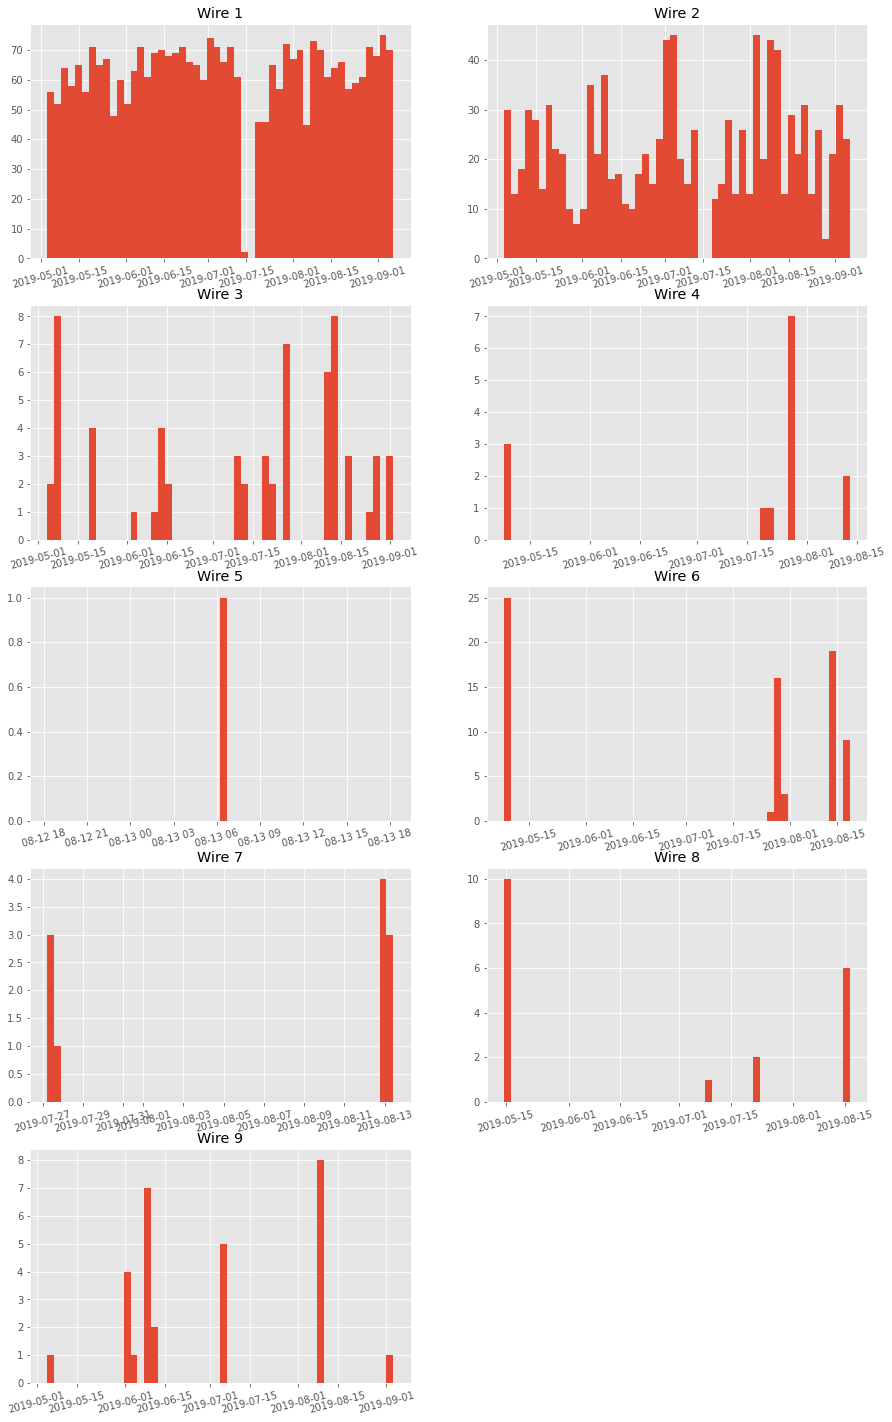

In [58]:
plt.figure(figsize=(15,25))
plt.style.use('ggplot')

pylab.subplot (5, 2, 1)
pylab.hist(data_wire_time['Wire 1'], bins = 50)
pylab.title ("Wire 1")
pylab.xticks(rotation=15)

pylab.subplot (5, 2, 2)
pylab.hist(data_wire_time['Wire 2'], bins = 50)
pylab.title ("Wire 2")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 3)
pylab.hist(data_wire_time['Wire 3'], bins = 50)
pylab.title ("Wire 3")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 4)
pylab.hist(data_wire_time['Wire 4'], bins = 50)
pylab.title ("Wire 4")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 5)
pylab.hist(data_wire_time['Wire 5'], bins = 50)
pylab.title ("Wire 5")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 6)
pylab.hist(data_wire_time['Wire 6'], bins = 50)
pylab.title ("Wire 6")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 7)
pylab.hist(data_wire_time['Wire 7'], bins = 50)
pylab.title ("Wire 7")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 8)
pylab.hist(data_wire_time['Wire 8'], bins = 50)
pylab.title ("Wire 8")
pylab.xticks(rotation=15)


pylab.subplot (5, 2, 9)
pylab.hist(data_wire_time['Wire 9'], bins = 50)
pylab.title ("Wire 9")
pylab.xticks(rotation=15)

plt.show()

Видно что и тут так же пропуски в июле.

Заметила что везед разное количество ключей во всех таблица, поэтому следующий шаг: агрегация. 

## Дополнительные признаки, предабработка данных 2

### Температура

In [59]:
data_temp

key        Время замера  Температура
0         1 2019-05-03 11:02:04       1571.0
1         1 2019-05-03 11:07:18       1604.0
2         1 2019-05-03 11:11:34       1618.0
3         1 2019-05-03 11:18:04       1601.0
4         1 2019-05-03 11:25:59       1606.0
...     ...                 ...          ...
18087  3241 2019-09-06 16:55:01          NaN
18088  3241 2019-09-06 17:06:38          NaN
18089  3241 2019-09-06 17:21:48          NaN
18090  3241 2019-09-06 17:24:44          NaN
18091  3241 2019-09-06 17:30:05          NaN

[18092 rows x 3 columns]

In [60]:
# удалила строки с пропусками в температуре
data_temp = data_temp.dropna(subset=['Температура'])

In [61]:
# убрала из таблицы ключи в которых температура встречается 1 раз 
data_temp_counts_key_1 = data_temp['key'].value_counts()[data_temp['key'].value_counts() == 1]
for i in range(len(data_temp_counts_key_1.index)):
    data_temp = data_temp[data_temp['key'] != data_temp_counts_key_1.index[i]]

In [62]:
#проверила что в колонке время нет повторяющихся значений, тоесть у всех ключей разное время
data_temp['Время замера'].value_counts()[data_temp['Время замера'].value_counts() != 1]

Series([], Name: Время замера, dtype: int64)

In [63]:
# min время для каждого ключа
data_temp_groupby_min = data_temp.groupby(by ='key').agg({'Время замера':['min']})
data_temp_groupby_min.columns = ['Время замера']

# max время для каждого ключа
data_temp_groupby_max = data_temp.groupby(by ='key').agg({'Время замера':['max']})
data_temp_groupby_max.columns = ['Время замера']

#объединяю таблицы добавляя мин температуру
temp_min = data_temp_groupby_min.merge(data_temp, on=['Время замера'], how='left')
temp_min.columns = ['Время замера', 'key', 'Температура мин']

#объединяю таблицы добавляя мах температуру
temp_max = data_temp_groupby_max.merge(data_temp, on=['Время замера'], how='left')
temp_max.columns = ['Время замера', 'key', 'Температура мах']

#создаю таблицу с мах и мин температурой, без колонок со временем
temp = temp_min.merge(temp_max, on=['key'], how='left')
temp = temp.drop(['Время замера_x','Время замера_y'], axis=1)

temp

key  Температура мин  Температура мах
0        1           1571.0           1613.0
1        2           1581.0           1602.0
2        3           1596.0           1599.0
3        4           1601.0           1625.0
4        5           1576.0           1602.0
...    ...              ...              ...
2470  2495           1570.0           1591.0
2471  2496           1554.0           1591.0
2472  2497           1571.0           1589.0
2473  2498           1591.0           1594.0
2474  2499           1569.0           1603.0

[2475 rows x 3 columns]

In [64]:
temp[temp['Температура мин'] < 1500]

key  Температура мин  Температура мах
853    867           1191.0           1599.0
1199  1214           1208.0           1591.0
1602  1619           1218.0           1590.0
2034  2052           1227.0           1592.0

In [65]:
#удалила все ключи у которых температура ниже 1500
key_bed = [867, 1214, 1619, 2052]
for i in range(len(key_bed)):
    temp = temp[temp['key'] != key_bed[i]]
    
temp

key  Температура мин  Температура мах
0        1           1571.0           1613.0
1        2           1581.0           1602.0
2        3           1596.0           1599.0
3        4           1601.0           1625.0
4        5           1576.0           1602.0
...    ...              ...              ...
2470  2495           1570.0           1591.0
2471  2496           1554.0           1591.0
2472  2497           1571.0           1589.0
2473  2498           1591.0           1594.0
2474  2499           1569.0           1603.0

[2471 rows x 3 columns]

In [66]:
temp[temp['Температура мин'] < 1500]

Empty DataFrame
Columns: [key, Температура мин, Температура мах]
Index: []

### Мощьность

In [67]:
data_bulk

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0        NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1        NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2        NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3        NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4        NaN      NaN      NaN    203.0      NaN    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0  

[3129 rows x 16 columns]

In [68]:
data_arc['Полная мощность'] = (((data_arc['Активная мощность']) ** 2) + (data_arc['Реактивная мощность'])**2) ** 1/2

In [69]:
data_arc['Нагрев в сек'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc['Работа'] = data_arc['Нагрев в сек'] * data_arc['Полная мощность']
#data_arc['КПД'] = round(data_arc['Активная мощность'] / data_arc['Реактивная мощность'] * 100)

In [70]:
data_arc = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
data_arc

key  Активная мощность  Реактивная мощность  Полная мощность  \
0         1           0.305130             0.211253         0.068866   
1         1           0.765658             0.477438         0.407090   
2         1           0.580313             0.430460         0.261029   
3         1           0.518496             0.379979         0.206611   
4         1           0.867133             0.643691         0.583129   
...     ...                ...                  ...              ...   
14871  3241           0.439735             0.299579         0.141557   
14872  3241           0.646498             0.458240         0.313972   
14873  3241           1.039726             0.769302         0.836428   
14874  3241           0.530267             0.361543         0.205948   
14875  3241           0.389057             0.251347         0.107270   

       Нагрев в сек      Работа  
0               228   15.701465  
1               185   75.311578  
2               172   44.897073  
3               365   75.413041  
4               148   86.303073  
...             ...         ...  
14871           157   22.224484  
14872           180   56.514921  
14873           184  153.902726  
14874            57   11.739048  
14875            81    8.688897  

[14875 rows x 6 columns]

In [71]:
data_arc = data_arc.groupby('key').sum()
data_arc['КПД%'] = round(data_arc['Активная мощность'] / data_arc['Реактивная мощность'] * 100)
data_arc

Активная мощность  Реактивная мощность  Полная мощность  Нагрев в сек  \
key                                                                           
1              3.036730             2.142821         1.526725          1098   
2              2.139408             1.453357         0.978428           811   
3              4.063641             2.937457         2.878388           655   
4              2.706489             2.056992         1.607567           741   
5              2.252950             1.687991         1.123995           869   
...                 ...                  ...              ...           ...   
3237           2.541872             2.025417         1.435005           909   
3238           1.374821             1.038103         0.546392           546   
3239           4.848005             3.541541         2.415132          1216   
3240           3.317679             2.373552         1.972458           839   
3241           3.045283             2.140011         1.605175           659   

          Работа   КПД%  
key                      
1     297.626229  142.0  
2     174.413527  147.0  
3     437.612335  138.0  
4     336.082330  132.0  
5     165.265814  133.0  
...          ...    ...  
3237  306.072661  125.0  
3238   85.786335  132.0  
3239  386.017358  137.0  
3240  302.797875  140.0  
3241  253.070076  142.0  

[3214 rows x 6 columns]

### Итоговая таблица

In [72]:
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)
data_gas.fillna(0, inplace=True)

In [73]:
df = temp.merge(data_arc, on=['key'], how='inner')

In [74]:
df = df.merge(data_gas, on=['key'], how='inner')

In [75]:
df = df.merge(data_bulk, on=['key'], how='inner')
df = df.merge(data_wire, on=['key'], how='inner')

In [76]:
df.describe() 

key  Температура мин  Температура мах  Активная мощность  \
count  2325.000000      2325.000000      2325.000000        2325.000000   
mean   1251.512258      1587.365161      1593.366022           3.125813   
std     715.099053        23.623144        11.209581           1.220473   
min       1.000000      1519.000000      1541.000000           0.267676   
25%     629.000000      1571.000000      1587.000000           2.295820   
50%    1255.000000      1587.000000      1593.000000           3.036303   
75%    1868.000000      1603.000000      1598.000000           3.834300   
max    2499.000000      1660.000000      1653.000000          12.375636   

       Реактивная мощность  Полная мощность  Нагрев в сек       Работа  \
count          2325.000000      2325.000000   2325.000000  2325.000000   
mean              2.300941         1.856149    807.988387   320.021237   
std               0.903664         0.945709    340.888430   193.018625   
min               0.196228         0.055078     57.000000     6.884742   
25%               1.670519         1.165915    581.000000   185.251970   
50%               2.225398         1.741028    778.000000   283.826847   
75%               2.829159         2.395893    993.000000   419.267399   
max               8.949049         8.314988   4189.000000  2579.445774   

              КПД%        Газ 1  ...      Bulk 15       Wire 1       Wire 2  \
count  2325.000000  2325.000000  ...  2325.000000  2325.000000  2325.000000   
mean    136.205161    11.378942  ...   120.026667   102.412198    17.605637   
std       6.963302     6.395632  ...    84.674380    43.535263    33.642919   
min     110.000000     0.008399  ...     0.000000     0.000000     0.000000   
25%     131.000000     7.282948  ...     0.000000    73.207679     0.000000   
50%     136.000000    10.100950  ...   107.000000   101.087998     0.000000   
75%     141.000000    14.217691  ...   204.000000   128.069763    23.102560   
max     166.000000    77.995040  ...   405.000000   330.314424   282.780152   

            Wire 3       Wire 4  Wire 5       Wire 6       Wire 7  \
count  2325.000000  2325.000000  2325.0  2325.000000  2325.000000   
mean      3.240481     0.307077     0.0     0.980504     0.006371   
std      27.966585     4.761821     0.0     8.700682     0.205882   
min       0.000000     0.000000     0.0     0.000000     0.000000   
25%       0.000000     0.000000     0.0     0.000000     0.000000   
50%       0.000000     0.000000     0.0     0.000000     0.000000   
75%       0.000000     0.000000     0.0     0.000000     0.000000   
max     385.008668   113.231044     0.0   180.454575     8.490040   

            Wire 8       Wire 9  
count  2325.000000  2325.000000  
mean      0.311847     0.317658  
std       4.406475     3.459510  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max     102.762401    62.025600  

[8 rows x 34 columns]

Wire 5 Странный столбец, мин и мах все по 0, видимо данные которые там были ушли после обработке, удалю этот столбец

In [77]:
df = df.drop(['Wire 5'], axis=1)

In [78]:
#df = df.dropna()
df.isna().sum()

key                    0
Температура мин        0
Температура мах        0
Активная мощность      0
Реактивная мощность    0
Полная мощность        0
Нагрев в сек           0
Работа                 0
КПД%                   0
Газ 1                  0
Bulk 1                 0
Bulk 2                 0
Bulk 3                 0
Bulk 4                 0
Bulk 5                 0
Bulk 6                 0
Bulk 7                 0
Bulk 8                 0
Bulk 9                 0
Bulk 10                0
Bulk 11                0
Bulk 12                0
Bulk 13                0
Bulk 14                0
Bulk 15                0
Wire 1                 0
Wire 2                 0
Wire 3                 0
Wire 4                 0
Wire 6                 0
Wire 7                 0
Wire 8                 0
Wire 9                 0
dtype: int64

Итоговую таблицу df собрали, целевой признак в ней это температура мах, ее то мы и хотим предсказывать.

In [79]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [80]:
df_l = df.drop(['Активная мощность', 'Реактивная мощность', 'key'], axis=1)
df_l = df_l.drop(['Нагрев в сек', 'Bulk 9', 'Полная мощность', ], axis=1)
corr = df_l.corr()
corr.style.background_gradient(cmap='coolwarm')

In [81]:
df = df.drop(['key'], axis=1)
df

Температура мин  Температура мах  Активная мощность  \
0              1571.0           1613.0           3.036730   
1              1581.0           1602.0           2.139408   
2              1596.0           1599.0           4.063641   
3              1601.0           1625.0           2.706489   
4              1576.0           1602.0           2.252950   
...               ...              ...                ...   
2320           1570.0           1591.0           3.168133   
2321           1554.0           1591.0           4.174918   
2322           1571.0           1589.0           3.605239   
2323           1591.0           1594.0           3.202310   
2324           1569.0           1603.0           1.737084   

      Реактивная мощность  Полная мощность  Нагрев в сек      Работа   КПД%  \
0                2.142821         1.526725          1098  297.626229  142.0   
1                1.453357         0.978428           811  174.413527  147.0   
2                2.937457         2.878388           655  437.612335  138.0   
3                2.056992         1.607567           741  336.082330  132.0   
4                1.687991         1.123995           869  165.265814  133.0   
...                   ...              ...           ...         ...    ...   
2320             2.210936         2.001960           723  360.716871  143.0   
2321             2.872031         2.842456           940  476.936854  145.0   
2322             2.452092         3.195647           569  600.436928  147.0   
2323             2.239820         1.731759           750  257.744525  143.0   
2324             1.296836         0.667875           883  179.625279  134.0   

          Газ 1  Bulk 1  ...  Bulk 14  Bulk 15      Wire 1    Wire 2  Wire 3  \
0     29.749986     0.0  ...    150.0    154.0   60.059998   0.00000     0.0   
1     12.555561     0.0  ...    149.0    154.0   96.052315   0.00000     0.0   
2     28.554793     0.0  ...    152.0    153.0   91.160157   0.00000     0.0   
3     18.841219     0.0  ...    153.0    154.0   89.063515   0.00000     0.0   
4      5.413692     0.0  ...    151.0    152.0   89.238236   9.11456     0.0   
...         ...     ...  ...      ...      ...         ...       ...     ...   
2320   7.125735     0.0  ...    129.0    223.0   89.150879   0.00000     0.0   
2321   9.412616     0.0  ...    129.0    226.0  114.179527   0.00000     0.0   
2322   6.271699     0.0  ...    124.0    226.0   94.086723   9.04800     0.0   
2323  14.953657     0.0  ...    129.0    207.0  118.110717   0.00000     0.0   
2324  11.336151     0.0  ...    126.0    227.0  110.160958  50.00528     0.0   

      Wire 4  Wire 6  Wire 7  Wire 8  Wire 9  
0        0.0     0.0     0.0     0.0     0.0  
1        0.0     0.0     0.0     0.0     0.0  
2        0.0     0.0     0.0     0.0     0.0  
3        0.0     0.0     0.0     0.0     0.0  
4        0.0     0.0     0.0     0.0     0.0  
...      ...     ...     ...     ...     ...  
2320     0.0     0.0     0.0     0.0     0.0  
2321     0.0     0.0     0.0     0.0     0.0  
2322     0.0     0.0     0.0     0.0     0.0  
2323     0.0     0.0     0.0     0.0     0.0  
2324     0.0     0.0     0.0     0.0     0.0  

[2325 rows x 32 columns]

## Модель

In [82]:
features = df.drop(['Температура мах'], axis=1)
target = df['Температура мах']

In [83]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [84]:
features_l = df_l.drop(['Температура мах'], axis=1)
target_l = df_l['Температура мах']

In [85]:
features_train_l, features_test_l, target_train_l, target_test_l = train_test_split(
    features_l, target_l, test_size=0.25, random_state=RANDOM_STATE)

In [86]:
scaler = StandardScaler()
scaler.fit(features_train_l)
features_train_l = scaler.transform(features_train_l)
features_test_l = scaler.transform(features_test_l)

### LinearRegression

In [87]:
%%time
model_LR = LinearRegression()
scores_LR = cross_val_score(model_LR,
                            features_train_l,
                            target_train_l,
                            cv=10,
                            verbose=10,
                            n_jobs=-1,
                            scoring='neg_mean_absolute_error') 
MAE_LR = (scores_LR * (-1)).mean()
print('MAE для линейной регрессии:', MAE_LR)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s


[CV] START .....................................................................
[CV] END ............................... score: (test=-6.747) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.401) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.190) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.722) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.263) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-5.804) total time=   0.1s
[CV] START .................

[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


### RandomForestRegressor

In [88]:
%%time
model_RFR = RandomForestRegressor(random_state=RANDOM_STATE)
param_search = { 
    'n_estimators': [i for i in range(50, 701, 50)],
    'max_depth' : [i for i in range(1,10, 1)]}

gsearch_RFR = GridSearchCV(estimator=model_RFR, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=10,
                           param_grid=param_search, 
                           scoring = 'neg_mean_absolute_error')
gsearch_RFR.fit(features_train, target_train)

best_score_RFR = gsearch_RFR.best_score_
best_model_RFR = gsearch_RFR.best_estimator_
print(-best_score_RFR)
print('-------------------')
print(best_model_RFR)
print('-------------------')
print(gsearch_RFR.best_params_)

Fitting 3 folds for each of 126 candidates, totalling 378 fits
[CV 1/3; 1/126] START max_depth=1, n_estimators=50..............................
[CV 1/3; 1/126] END ............max_depth=1, n_estimators=50; total time=   0.2s
[CV 2/3; 1/126] START max_depth=1, n_estimators=50..............................
[CV 2/3; 1/126] END ............max_depth=1, n_estimators=50; total time=   0.1s
[CV 3/3; 1/126] START max_depth=1, n_estimators=50..............................
[CV 3/3; 1/126] END ............max_depth=1, n_estimators=50; total time=   0.1s
[CV 1/3; 2/126] START max_depth=1, n_estimators=100.............................
[CV 1/3; 2/126] END ...........max_depth=1, n_estimators=100; total time=   0.2s
[CV 2/3; 2/126] START max_depth=1, n_estimators=100.............................
[CV 2/3; 2/126] END ...........max_depth=1, n_estimators=100; total time=   0.2s
[CV 3/3; 2/126] START max_depth=1, n_estimators=100.............................
[CV 3/3; 2/126] END ...........max_depth=1, n_

### CatBoostRegressor

In [89]:
model_cat = CatBoostRegressor(random_state=RANDOM_STATE)

grid = {'learning_rate': [0.03, 0.04, 0.02],
        'depth': [i for i in range(4, 10, 1)]}

gsearch_cat = GridSearchCV(estimator=model_cat, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=10,
                           scoring='neg_root_mean_squared_error',
                           param_grid=grid)
gsearch_cat.fit(features_train, target_train)

best_score_cat = gsearch_cat.best_score_
best_model_cat = gsearch_cat.best_estimator_
print(-best_score_cat)
print('-------------------')
print(best_model_cat)
print('-------------------')
print(gsearch_cat.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START depth=4, learning_rate=0.03................................
0:	learn: 11.0886620	total: 47.6ms	remaining: 47.5s
1:	learn: 11.0276263	total: 49.1ms	remaining: 24.5s
2:	learn: 10.9739399	total: 50.3ms	remaining: 16.7s
3:	learn: 10.9130071	total: 51.5ms	remaining: 12.8s
4:	learn: 10.8660184	total: 52.7ms	remaining: 10.5s
5:	learn: 10.8199861	total: 54ms	remaining: 8.94s
6:	learn: 10.7657506	total: 55.2ms	remaining: 7.83s
7:	learn: 10.6996385	total: 56.4ms	remaining: 6.99s
8:	learn: 10.6514179	total: 57.7ms	remaining: 6.35s
9:	learn: 10.6040128	total: 58.9ms	remaining: 5.83s
10:	learn: 10.5524810	total: 60ms	remaining: 5.4s
11:	learn: 10.5065025	total: 61.2ms	remaining: 5.04s
12:	learn: 10.4570467	total: 62.4ms	remaining: 4.74s
13:	learn: 10.4000357	total: 63.5ms	remaining: 4.47s
14:	learn: 10.3623589	total: 64.6ms	remaining: 4.24s
15:	learn: 10.3300584	total: 65.9ms	remaining: 4.05s
16:	learn: 10.2935750	tot

### LightGMB

In [90]:
%%time
model_LGBMR = LGBMRegressor(random_state=RANDOM_STATE)

param_grid = {'n_estimators': [100, 500, 1000], 
              'num_leaves': [10, 20, 30],
              'max_depth': [i for i in range(5,10)],
             'max_lag': [24]}

gsearch_LGBMR = GridSearchCV(estimator=model_LGBMR,
                             param_grid=param_grid,
                             n_jobs=-1, 
                             verbose=10,
                             scoring='neg_mean_absolute_error',
                             cv=3)

gsearch_LGBMR.fit(features_train, target_train)

print(-gsearch_LGBMR.best_score_)
print('-------------------')
print(gsearch_LGBMR.best_estimator_)
print('-------------------')
print(gsearch_LGBMR.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3; 1/45] START max_depth=5, max_lag=24, n_estimators=100, num_leaves=10...
[LightGBM] [Warning] Unknown parameter: max_lag
[CV 1/3; 1/45] END max_depth=5, max_lag=24, n_estimators=100, num_leaves=10; total time=   0.3s
[CV 2/3; 1/45] START max_depth=5, max_lag=24, n_estimators=100, num_leaves=10...
[LightGBM] [Warning] Unknown parameter: max_lag
[CV 2/3; 1/45] END max_depth=5, max_lag=24, n_estimators=100, num_leaves=10; total time=   0.6s
[CV 3/3; 1/45] START max_depth=5, max_lag=24, n_estimators=100, num_leaves=10...
[LightGBM] [Warning] Unknown parameter: max_lag
[CV 3/3; 1/45] END max_depth=5, max_lag=24, n_estimators=100, num_leaves=10; total time=   0.5s
[CV 1/3; 2/45] START max_depth=5, max_lag=24, n_estimators=100, num_leaves=20...
[LightGBM] [Warning] Unknown parameter: max_lag
[CV 1/3; 2/45] END max_depth=5, max_lag=24, n_estimators=100, num_leaves=20; total time=   0.5s
[CV 2/3; 2/45] START max_depth=5, max_

### DummyRegressor

In [91]:
%%time
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predict_dummy_mean = dummy_regr.predict(features_test)
MAE_DR = mean_squared_error(target_test, predict_dummy_mean) ** 0.5
MAE_DR

CPU times: user 1.56 ms, sys: 0 ns, total: 1.56 ms
Wall time: 1.17 ms


11.295394131246077

## Анализ моделей

In [92]:
index = ['MAE']
analysis = {'LinearRegression':[MAE_LR],
            'RandomForestRegressor':[-best_score_RFR],
            'CatBoostRegressor':[-best_score_cat],
            'LGBMRegressor':[-gsearch_LGBMR.best_score_],
            'DummyRegressor':[MAE_DR]}
analysis_itog = pd.DataFrame(data=analysis, index=index)
analysis_itog

LinearRegression  RandomForestRegressor  CatBoostRegressor  \
MAE          6.894565               6.362488           8.698187   

     LGBMRegressor  DummyRegressor  
MAE       6.335116       11.295394

## Проверка на тестовой выборки

Выберу лучшую модель LightGMB и проверю ее на тестовой выборке. 

In [93]:
model_LGBMR

LGBMRegressor(random_state=60623)

In [94]:

model_LGBMR.fit(features_train, target_train)
predict= model_LGBMR.predict(features_test)

MAE = mean_absolute_error(target_test, predict)
print("MAE:", MAE)

MAE: 6.376418341423489


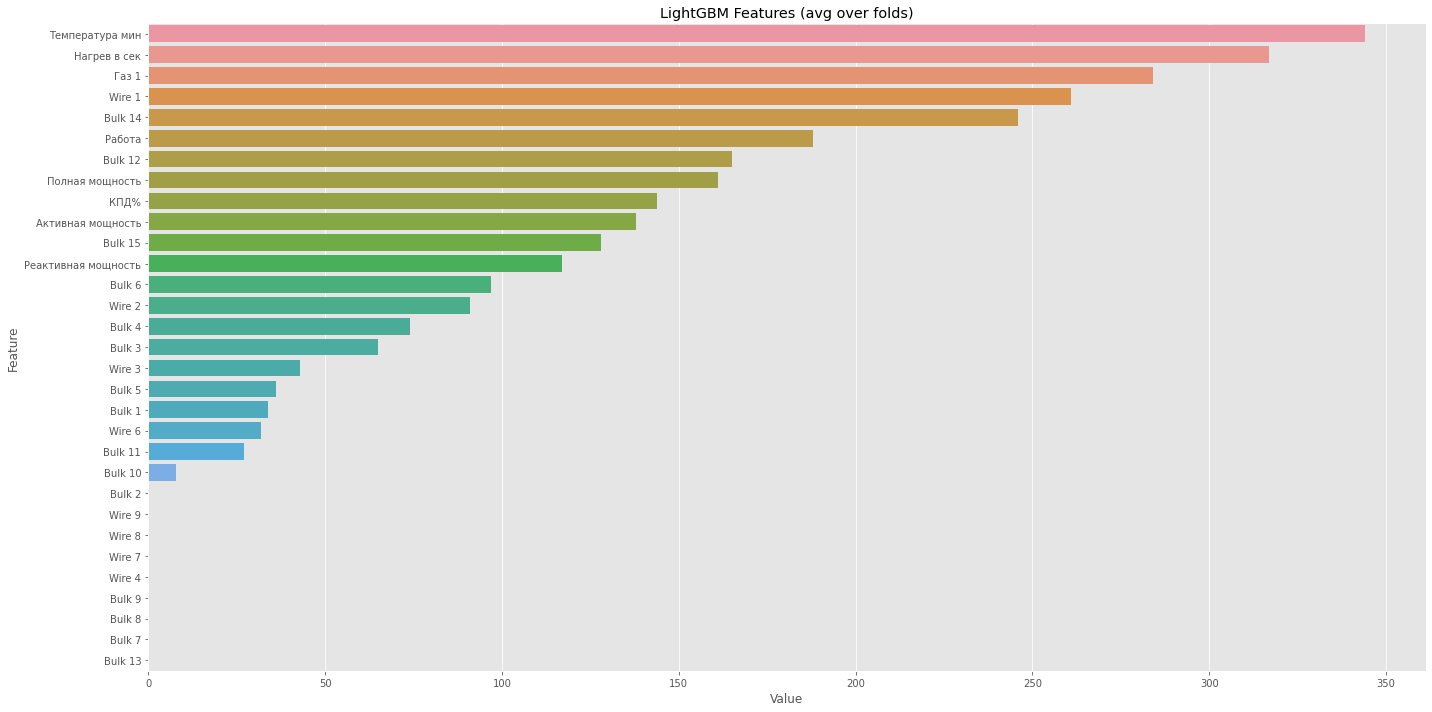

In [95]:
#к.р.
feature_imp = pd.DataFrame(sorted(zip(model_LGBMR.feature_importances_,features.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


Результат на тестовой выборке хороший, оставляем LinearRegression, думаю она лучше всего подойдет заказику.

## **Отчёт**

Проект выполнен одним специалистом по data science. Выполняа разлиные этапы обработки данных, создавала и сравнивала модели и окончательную модель тестировала на тестовых данных.

### ПЛАН

Я оптимизировала производственные расходы металлургического комбинат ООО «Так закаляем сталь», а именно строила модели для того, что бы предсказать температуру стали для уменьшения потребление электроэнергии на этапе обработки стали. Все пункты плана были выполнены в ходе работы над проектом. 

### Сбор и понимание данных 

Были полученны 7 файлов с данными. В каждом были проанализированны данные, построены графики их распределения и боксплоты. Расмотрена зависимость корелирующих функций. Поменены везде форматы дат. В таблице с температурой были оставлены для каждого ключа только начальная и конечная температура, ключи где нет конечной температуры были удалены. Так же ключи с температурой меньше 1500 были удалены по просьбе заказчика. Затем были расчитаны дополнительные призаки: полная мощность, время нагрева, работа, кпд в %. Ну и собрана итоговая таблица со всеми данными. 

### Моделирование

Перед обечением моделей, сначала были проанализированы корелирующие признаки в итогово таблице. Для модели линейной регрессии из таблицы были удалины сильно коррелирующие признаки, а именно: 'Активная мощность', 'Реактивная мощность', 'key', 'Нагрев в сек', 'Bulk 9', 'Полная мощность'. Для всех остальных моделей из итоговой таблицы был убран только столбец key. Дальше данные были разделены на обучающую и тестовую выборку, и данные для линейной регрессии прошли маштабирование признаков.  


После построили 5 моделей и расчитали показатель MAE, результаты в таблице ниже. 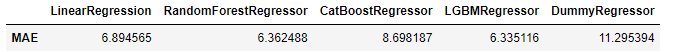

По этим результатам была выбрана лучшая модель LGBMRegressor: {'max_depth': 6, 'max_lag': 24, 'n_estimators': 100, 'num_leaves': 10}. 

Результат на тестовой выборке: MAE: 6.376418341423489. 

Важность функции модели показана ниже.
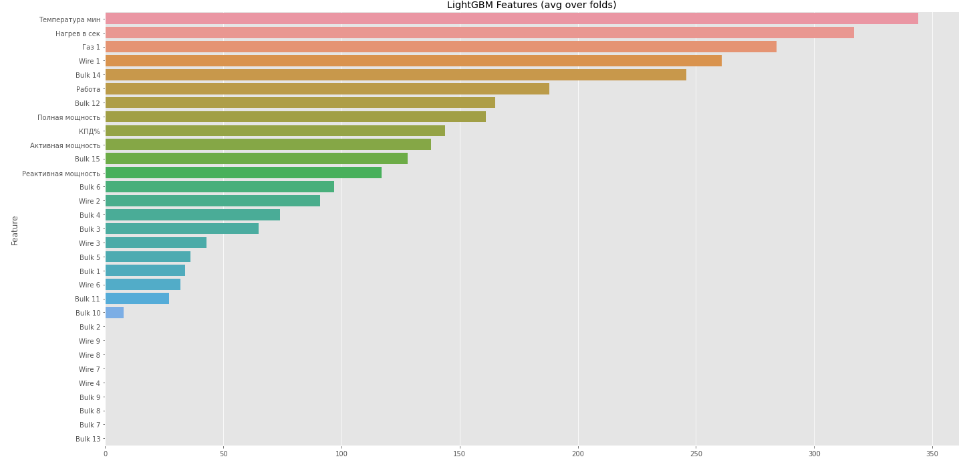

В итоге Хотелось порекомендовать заказчику внимательней измерят и заносит данные минимальной температуры, так как это самый важный признак. А в нем как раз то были и выбросы и аномалии. Такая же проблема и в остальных данных, большое количество пропусков, думаю если подредактировать данные со стороны заказчика, модель улучшит свои предсказания. 